# Load packages and define functions

In [1]:
import pandas as pd
import pyam
import numpy as np

import datatoolbox as dt

from pandas_indexing import *


import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
import seaborn as sns

ca_colors = ['#95AD28','#2C8090','#F0280E','#F0CF1C','#1478B0','#59C954','#059E73','#945EB0','#383836','#828282','#C2C2C2']
ca_colors = sns.color_palette(ca_colors)
ca_colors

from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Lato']

sns.set_palette(ca_colors)

import data_shepherd as ds
from data_shepherd import utils

import pycountry
from scipy.stats import linregress

<IPython.core.display.Javascript object>

Remote: (16) new sources and (2) updated sources are available online (see dt.available_remote_data_updates)
SSH agent not running, not checking for remote data.


In [2]:
def cap_add(tech):
    return f"Capacity Additions|Electricity|{tech}"

def cap(tech):
    return f"Capacity|Electricity|{tech}"

def elec(tech=None):
    if tech is None:
        return "Secondary Energy|Electricity"
    else:
        return f"Secondary Energy|Electricity|{tech}"

def inv(tech=None):
    if tech is None:
        return 'Investment|Energy Supply|Electricity'
    else:
        return f'Investment|Energy Supply|Electricity|{tech}'


def cost(tech):
    return f'Capital Cost|Electricity|{tech}'

In [3]:
filter_set = pd.read_csv('../../cat_benchmarks/data/processed/cat_filter_set_noregdif.csv',index_col=[0,1])
filter_set = [f'{m}|{s}' for m,s in filter_set.index]

# Define regions
We are using 6 major world regions, which are listed below with their names.

In [4]:
regions = ['R5OECD','R5ASIA','R10AFRICA','R10LATIN_AM','R10REF_ECON','R10MIDDLE_EAST','World']
region_names = ['OECD','Asia','Sub-Saharan Africa','Latin America','Eurasia','Middle East and North Africa','World']

Use the REMIND region mapping to determine which ISOS are inside each of these regions (justified as the majority of pathways being used are REMIND pathways)

In [5]:
remind_map = ds.utils.RegionMapping.from_model('R10_REMIND_2.1').iso_to_region
message_map = ds.utils.RegionMapping.from_model('R10_MESSAGE-GLOBIOM_1.2').iso_to_region
witch_map = ds.utils.RegionMapping.from_model('R10_WITCH_5.0').iso_to_region



oecd_isos = list(remind_map.loc[remind_map.isin(['R10EUROPE','R10NORTH_AM','R10PAC_OECD','R10ROWO'])].index)
asia_isos = list(remind_map.loc[remind_map.isin(['R10CHINA+','R10INDIA+','R10REST_ASIA'])].index)
africa_isos = list(remind_map.loc[remind_map.isin(['R10AFRICA'])].index)
latam_isos = list(remind_map.loc[remind_map.isin(['R10LATIN_AM'])].index)
ref_isos = list(remind_map.loc[remind_map.isin(['R10REF_ECON'])].index)
mideast_isos = list(remind_map.loc[remind_map.isin(['R10MIDDLE_EAST'])].index)
world_isos = list(remind_map.index)

eu27_isos = ds.utils.RegionMapping.from_model('EU27').iso_to_region.index

isos=[oecd_isos,asia_isos,africa_isos,latam_isos,ref_isos,mideast_isos,world_isos]

Check what difference in the region mapping there is between MESSAGE, REMIND and WITCH (the three models being used overall for the analysis)

In [6]:
regional_diff = pd.DataFrame(
    columns=['remind_message','remind_witch','message_witch'],
    index=regions[:-1])

regional_diff.index.names=['region']

In [7]:
def iso_to_name(iso):
    if pycountry.countries.get(alpha_3=iso) is None:
        return iso
    else:
        return  pycountry.countries.get(alpha_3=iso).name


In [8]:
for region in regional_diff.index[2:]:
    m_isos = set([iso_to_name(iso) for iso in message_map.loc[message_map.isin([region])].index])
    r_isos = set([iso_to_name(iso) for iso in remind_map.loc[remind_map.isin([region])].index])
    w_isos = set([iso_to_name(iso) for iso in witch_map.loc[witch_map.isin([region])].index])
    
    regional_diff.loc[region,'remind_message'] = dict(zip(
        ['REMIND_unique','MESSAGE_unique'],
        [list(r_isos-m_isos),list(m_isos-r_isos)])).items()

    regional_diff.loc[region,'remind_witch'] = dict(zip(
        ['REMIND_unique','WITCH_unique'],
        [list(r_isos-w_isos),list(w_isos-r_isos)])).items()
    
    regional_diff.loc[region,'message_witch'] = dict(zip(
        ['MESSAGE_unique','WITCH_unique'],
        [list(m_isos-w_isos),list(w_isos-m_isos)])).items()


for region, sub_regions in dict(zip(['R5OECD','R5ASIA'],[['R10EUROPE','R10NORTH_AM','R10PAC_OECD','R10ROWO'],['R10CHINA+','R10INDIA+','R10REST_ASIA']])).items():
    m_isos = set([iso_to_name(iso) for iso in message_map.loc[message_map.isin(sub_regions)].index])
    r_isos = set([iso_to_name(iso) for iso in remind_map.loc[remind_map.isin(sub_regions)].index])
    w_isos = set([iso_to_name(iso) for iso in witch_map.loc[witch_map.isin(sub_regions)].index])
    
    
    regional_diff.loc[region,'remind_message'] = dict(zip(
        ['REMIND_unique','MESSAGE_unique'],
        [list(r_isos-m_isos),list(m_isos-r_isos)])).items()

    regional_diff.loc[region,'remind_witch'] = dict(zip(
        ['REMIND_unique','WITCH_unique'],
        [list(r_isos-w_isos),list(w_isos-r_isos)])).items()
    
    regional_diff.loc[region,'message_witch'] = dict(zip(
        ['MESSAGE_unique','WITCH_unique'],
        [list(m_isos-w_isos),list(w_isos-m_isos)])).items()
    

regional_diff

remind_message  \
region                                                              
R5OECD          ((REMIND_unique, []), (MESSAGE_unique, [Virgin...   
R5ASIA          ((REMIND_unique, [Wallis and Futuna, Pitcairn,...   
R10AFRICA       ((REMIND_unique, [Mayotte, Saint Helena, Ascen...   
R10LATIN_AM     ((REMIND_unique, [Virgin Islands, British, Vir...   
R10REF_ECON           ((REMIND_unique, []), (MESSAGE_unique, []))   
R10MIDDLE_EAST  ((REMIND_unique, [Western Sahara]), (MESSAGE_u...   

                                                     remind_witch  \
region                                                              
R5OECD          ((REMIND_unique, [Turkey]), (WITCH_unique, [No...   
R5ASIA          ((REMIND_unique, [Norfolk Island, Marshall Isl...   
R10AFRICA       ((REMIND_unique, []), (WITCH_unique, [Bouvet I...   
R10LATIN_AM     ((REMIND_unique, [Bouvet Island]), (WITCH_uniq...   
R10REF_ECON     ((REMIND_unique, []), (WITCH_unique, [Mongolia...   
R10MIDDLE_EAST     ((REMIND_unique, [Sudan]), (WITCH_unique, []))   

                                                    message_witch  
region                                                             
R5OECD          ((MESSAGE_unique, [Virgin Islands, British, Vi...  
R5ASIA          ((MESSAGE_unique, [Vanuatu, Marshall Islands, ...  
R10AFRICA       ((MESSAGE_unique, [Western Sahara]), (WITCH_un...  
R10LATIN_AM     ((MESSAGE_unique, []), (WITCH_unique, [Virgin ...  
R10REF_ECON     ((MESSAGE_unique, []), (WITCH_unique, [Mongoli...  
R10MIDDLE_EAST  ((MESSAGE_unique, [South Sudan, Sudan]), (WITC...

# Load and process data

## 1.5ºC compatible scenarios

We produce a dataset of 1.5ºC compatible scenarios, produced by the combination of:
- Capacity data and wind/solar generation data from the IIASA AR6 explorer
- Shepherded data from the `data_shepherd` (but this is missing capacity / wind+solar splits, hence the use of IIASA above)
- Raw data from `LED_2019`, as regional capacity and wind/solar data is not available for the LED on the IIASA scenario explorer

First, load the capacity data and wind/solar generation data from IIASA AR6 scenario explorer

In [9]:
# ar6_conn = pyam.iiasa.Connection("ar6-public")

# # Prefilter pathways to reduce the amount of data needed to be downloaded
# meta = ar6_conn.meta()
# pathways_selection = meta.loc[
#     meta["Category_name"].str.contains("C1").replace(np.NaN, False)
# ]
# models = list(set(pathways_selection.index.get_level_values("model")))
# scenarios = list(set(pathways_selection.index.get_level_values("scenario")))


In [10]:
# additional_data_ar6 = ar6_conn.query(
#     model = models,
#     scenario=scenarios,
#     variable=[
#         cap('**'),
#         cap_add("**"),
#         elec('*Wind*'),
#         elec('*Solar*'),
#         inv(),
#         inv('**'),
#         cost('**'),
#     ]
# )
    
# additional_data_ar6 = additional_data_ar6.filter(Category="C1")
# additional_data_ar6.to_csv('../data/raw/additional_data_c1.csv')


additional_data = pyam.IamDataFrame('../data/raw/additional_data_c1.csv')
additional_data.meta["pathway"] = [f"{m}|{s}" for m,s in additional_data.meta.index]
additional_data.filter(scenario="*LowEnergyDemand*",keep=False,inplace=True)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/raw/additional_data_c1.csv


Load the shepherded data from the data_shepherd

In [11]:
ar6_data = pyam.IamDataFrame('../data/processed/input_data_harmonised.csv')
ar6_data.meta['pathway'] = [f'{m}|{s}' for m,s in ar6_data.meta.index]
ar6_data.filter(scenario="*LowEnergyDemand*",keep=False,inplace=True)

pyam.core - INFO: Reading file ../data/processed/input_data_harmonised.csv


We add in the LED scenario ourselves, using the raw data provided by IIASA

In [12]:
led_data = dt.findp(source='LED_2019',variable=[
    'Capacity**Elec**','Secondary_Energy|Elec**','Investment|Energy_Supply|Electricity**']).as_pyam().filter(
    variable=['**Biomass','**Geothermal','**Solar','**Wind','**Hydro','**Renewables','Secondary_Energy|Electricity','Investment|Energy_Supply|Electricity**'])

led_data = pyam.IamDataFrame(led_data.timeseries().rename(index=lambda s:s.replace('_',' ')))
led_data.rename(model={'MESSAGEix-GLOBIOM':'MESSAGEix-GLOBIOM 1.0'},
               scenario={'LowEnergyDemand':'LowEnergyDemand_1.3_IPCC'},
               inplace=True)

led_data.meta["pathway"] = [f"{m}|{s}" for m,s in led_data.meta.index]

In [13]:
for variable in led_data.variable:
    led_data.aggregate_region(
        variable,
        'R5OECD',
        ['EEU','NAM','WEU','PAO'],
        append=True)
    
    led_data.aggregate_region(
        variable,
        'R5ASIA',
        ['CPA','SAS','PAS'],
        append=True)

led_data.rename(
    region={'AFR':'R10AFRICA',
            'FSU':'R10REF_ECON',
            'MEA':'R10MIDDLE_EAST',
            'LAM':'R10LATIN_AM'},
    inplace=True)

led_data = led_data.filter(region=['R*','World'])

In [14]:
ar6_data = pyam.concat([led_data,ar6_data,additional_data])

Rename scenarios and add the necessary variables

In [15]:
r5_dict = dict(zip(
    [
    'Asian countries except Japan',
    'Countries from the Reforming Ecomonies of the Former Soviet Union',
    'Countries of the Middle East and Africa',
    'OECD90 and EU (and EU candidate) countries',
    'Latin American countries'],
    ['R5ASIA','R5REF','R5MAF','R5OECD','R5LAM']
))

In [16]:
r10_dict = dict(zip([
    'Countries of Latin America and the Caribbean',
    'Countries of South Asia; primarily India',
    'Countries of Sub-Saharan Africa',
    'Countries of centrally-planned Asia; primarily China',
    'Countries of the Middle East; Iran, Iraq, Israel, Saudi Arabia, Qatar, etc.',
    'Eastern and Western Europe (i.e., the EU28)',
    'North America; primarily the United States of America and Canada',
    'Other countries of Asia',
    'Pacific OECD',
    'Reforming Economies of Eastern Europe and the Former Soviet Union; primarily Russia',
    'Rest of the World (R10)',
],
                    [
    'R10LATIN_AM',
    'R10INDIA+',
    'R10AFRICA',
    'R10CHINA+',
    'R10MIDDLE_EAST',
    'R10EUROPE',
    'R10NORTH_AM',
    'R10REST_ASIA',
    'R10PAC_OECD',
    'R10REF_ECON',
    'R10ROWO'
                    ]))

In [17]:
led_data

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : MESSAGEix-GLOBIOM 1.0 (1)
 * scenario : LowEnergyDemand_1.3_IPCC (1)
Timeseries data coordinates:
   region   : R10AFRICA, R10REF_ECON, R10LATIN_AM, R10MIDDLE_EAST, ... World (7)
   variable : Capacity Additions|Electricity|Biomass, ... (40)
   unit     : EJ/yr, GW, billion USD2010/yr (3)
   year     : 2000, 2005, 2010, 2020, 2030, 2040, 2050, 2060, ... 2100 (12)
Meta indicators:
   exclude (bool) False (1)
   pathway (object) MESSAGEix-GLOBIOM 1.0|LowEnergyDemand_1.3_IPCC (1)

In [18]:
ar6_data = ar6_data.rename(region=r10_dict).rename(region=r5_dict).filter(
    region=list(r10_dict.values())+list(r5_dict.values())+['World'])

In [19]:
ar6_data.add(
    cap('Wind'),
    cap('Solar'),
    cap('WnS'),
    append=True)

ar6_data.add(
    cap_add('Wind'),
    cap_add('Solar'),
    cap_add('WnS'),
    append=True)


ar6_data.add(
    elec('Wind'),
    elec('Solar'),
    elec('WnS'),
    append=True)

ar6_data.filter(variable=[cap('Ren**'),cap_add('Ren**')],keep=False,inplace=True)

ar6_data.aggregate(
    cap_add('Renewables'),
    [  
        cap_add('Solar'),
        cap_add('Wind'),
        cap_add('Biomass'),
        cap_add('Geothermal'),
        cap_add('Hydro'),
        cap_add('Ocean')
    ],
    append=True)

ar6_data.aggregate(
    cap('Renewables'),
    [  
        cap('Solar'),
        cap('Wind'),
        cap('Biomass'),
        cap('Geothermal'),
        cap('Hydro'),
        cap('Ocean')
    ],
    append=True)

ar6_data.aggregate(
    elec('Renewables'),
    [  
        elec('Non-Biomass Renewables'),
        elec('Biomass'),
    ],
    append=True)


/opt/homebrew/Caskroom/mambaforge/base/envs/ca_general/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1594: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


In [20]:
ar6_data.divide(
    elec('WnS'),
    elec(),
    elec('WnS|share'),
    ignore_units='',
    append=True)

ar6_data.divide(
    elec('Renewables'),
    elec(),
    elec('Renewables|share'),
    ignore_units='',
    append=True)

ar6_data.convert_unit('','%',factor=1e2,inplace=True)

In [21]:
ar6_data.rename(
    unit={'billion US$2010/yr':'billion USD_2010/yr',
         'billion USD2010/yr':'billion USD_2010/yr'},
inplace=True)

In [22]:
ar6_data.filter(variable=inv('Renewables**'),keep=False,inplace=True)

ar6_data.add(
    inv('Non-Biomass Renewables'),
    inv('Biomass'),
    inv('Renewables'),
    append=True)

ar6_data.add(
    inv('Wind'),
    inv('Solar'),
    inv('WnS'),
    append=True)

In [23]:
ar6_data.add(
    inv('Transmission and Distribution'),
    inv('Electricity Storage'),
    inv('Transmission, Distribution and Storage'),
    append=True)

### Add missing capacity additions data
Some models do not report capacity additions data. This is added based on the relationship between capacity and capacity additions in the models where this is provided

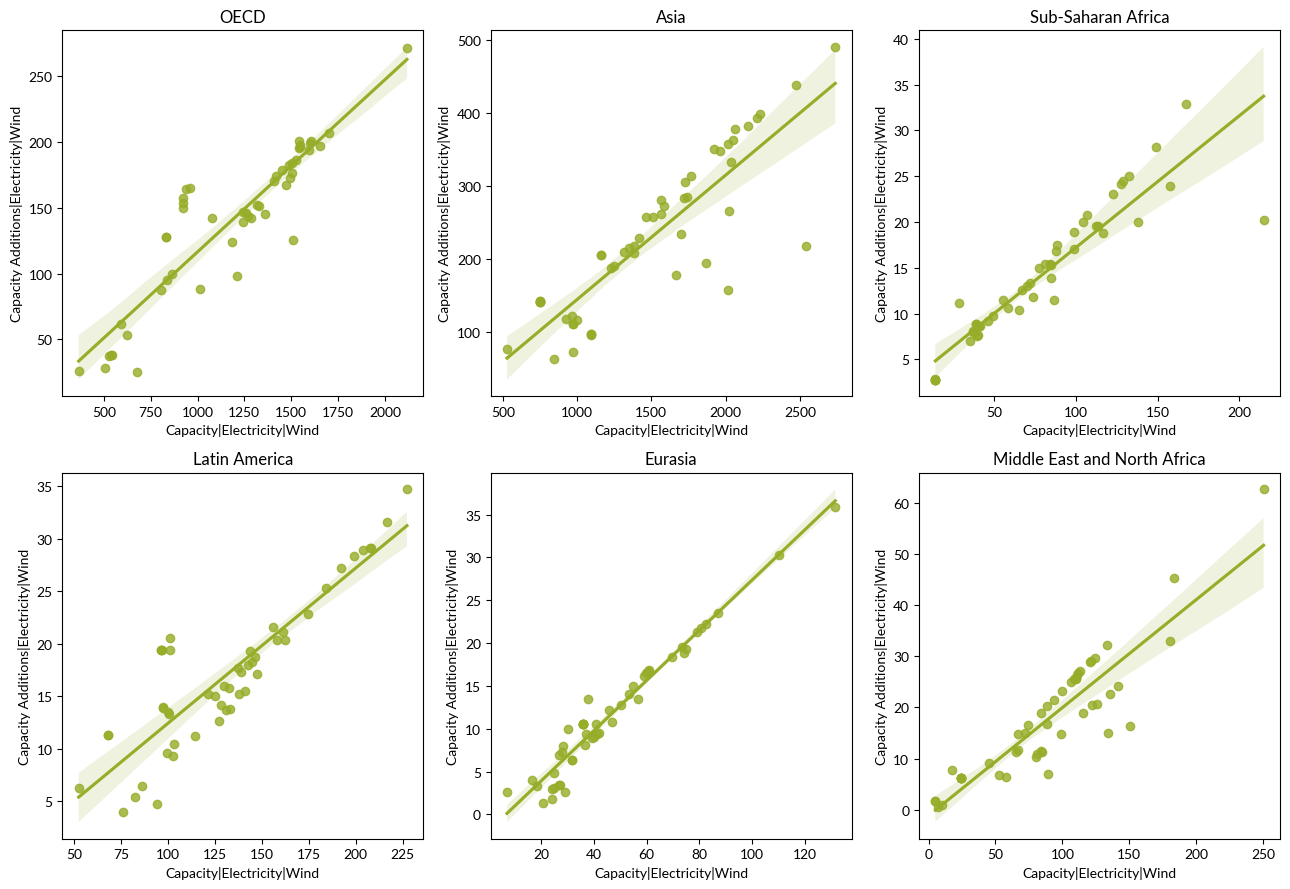

In [24]:
f, axes = plt.subplots(nrows=2,ncols=3,figsize=(13,9))

for count, ax in enumerate(axes.ravel()):
    sns.regplot(
        x = 'Capacity|Electricity|Wind',
        y = 'Capacity Additions|Electricity|Wind',
        data = ar6_data.filter(
            variable=[cap_add('Wind'),cap('Wind')],
            year=2030,
            region=regions[count],
        )._data.droplevel('unit').unstack('variable').dropna(),
        ax=ax)

    ax.set_title(region_names[count])

plt.tight_layout()
                

In [25]:
def regression_format(tech):
    result = ar6_data.filter(
    variable=[cap_add(tech),cap(tech)],
    year=2030,
    region=regions)
    
    output = (result
              ._data.droplevel('unit')
              .unstack('variable').dropna().groupby('region')
              .apply(lambda x:linregress(
                  x[f'Capacity|Electricity|{tech}'],
                  x[f'Capacity Additions|Electricity|{tech}']))
             )

    output = pd.concat(
        [output.apply(lambda x:x.slope),output.apply(lambda x:x.intercept)],axis=1)
    
    output.columns=['slope','intercept']
    return(output)


In [26]:
techs = ['Wind','Wind|Onshore','Wind|Offshore','Solar','Solar|PV','WnS','Renewables']
# test = ar6_data.copy()

for tech in techs[:]:
    for region in regions[:]:
        ar6_data.require_data(
        variable=cap_add(tech),
        region=region,
        exclude_on_fail=True)
    
    
        missing_data =(
            ar6_data
            .filter(exclude=True,variable=cap(tech),region=region)
            .timeseries()
            .multiply(regression_format(tech).slope,axis='index')
            .add(regression_format(tech).intercept,axis='index')
            .clip(lower=0)
            # .groupby(['region','variable']).median()
            .rename(index=lambda s:s.replace('Capacity','Capacity Additions').replace('GW','GW/yr'))
        )
    
        ar6_data = pyam.concat([ar6_data,missing_data])
        ar6_data.meta['exclude'] = False


pyam.core - INFO: 92 non-valid scenarios will be excluded
pyam.core - INFO: 91 non-valid scenarios will be excluded
pyam.core - INFO: 94 non-valid scenarios will be excluded
pyam.core - INFO: 92 non-valid scenarios will be excluded
pyam.core - INFO: 92 non-valid scenarios will be excluded
pyam.core - INFO: 92 non-valid scenarios will be excluded
pyam.core - INFO: 84 non-valid scenarios will be excluded
pyam.core - INFO: 126 non-valid scenarios will be excluded
pyam.core - INFO: 125 non-valid scenarios will be excluded
pyam.core - INFO: 128 non-valid scenarios will be excluded
pyam.core - INFO: 126 non-valid scenarios will be excluded
pyam.core - INFO: 126 non-valid scenarios will be excluded
pyam.core - INFO: 126 non-valid scenarios will be excluded
pyam.core - INFO: 118 non-valid scenarios will be excluded
pyam.core - INFO: 128 non-valid scenarios will be excluded
pyam.core - INFO: 128 non-valid scenarios will be excluded
pyam.core - INFO: 130 non-valid scenarios will be excluded
pyam

### Add missing investments data
Some of the REMIND pathways do not report investments data. This is added based on the relationship between key variables and investments for the REMIND pathways where there is data

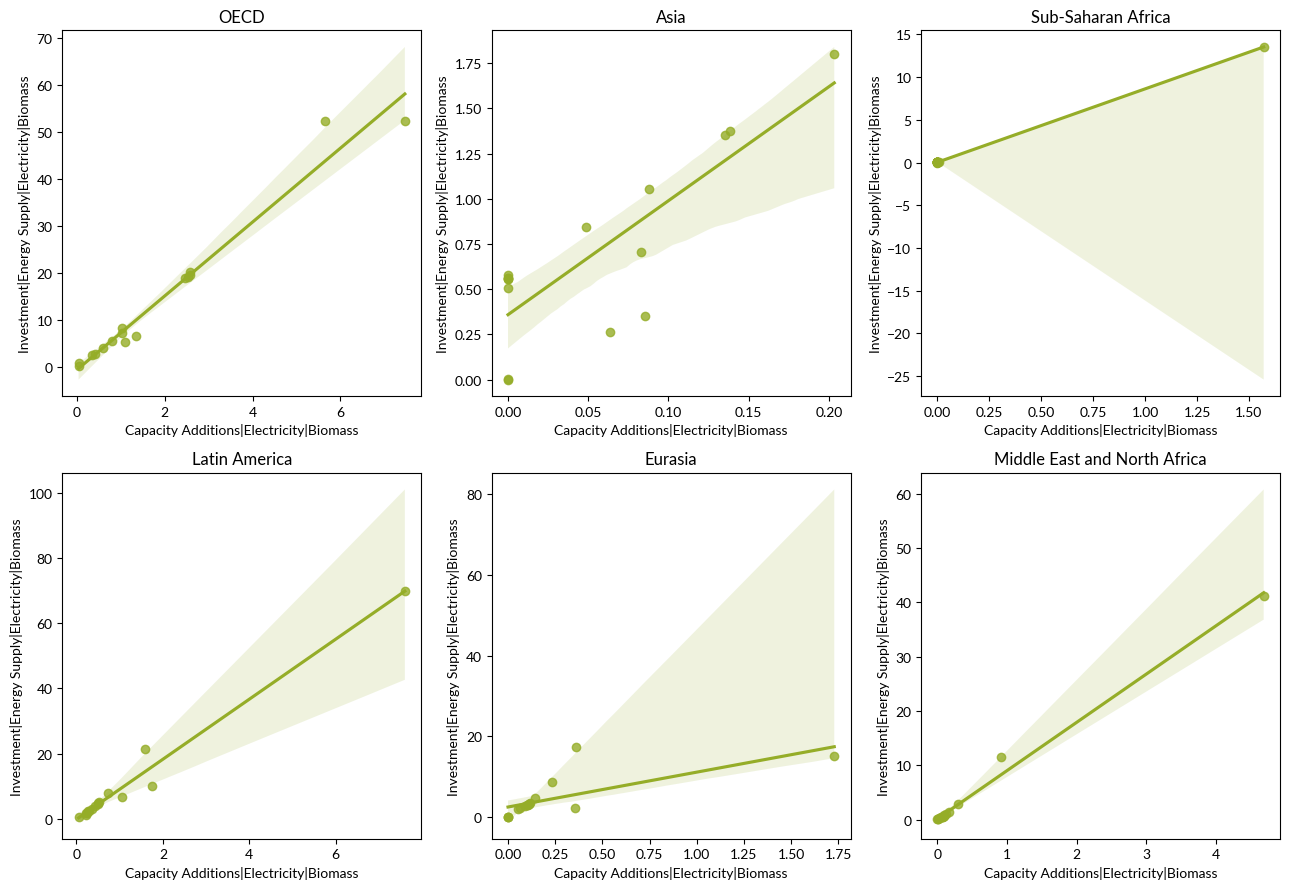

In [27]:
f, axes = plt.subplots(nrows=2,ncols=3,figsize=(13,9))

for count, ax in enumerate(axes.ravel()):
    sns.regplot(
        x = cap_add('Biomass'),
        y = inv('Biomass'),
        data = ar6_data.filter(
            variable=[inv('Biomass'),cap_add('Biomass')],
            model='REMIND**',
            year=2030,
            region=regions[count],
        )._data.droplevel('unit').unstack('variable').dropna(),
        ax=ax)

    ax.set_title(region_names[count])

plt.tight_layout()
                

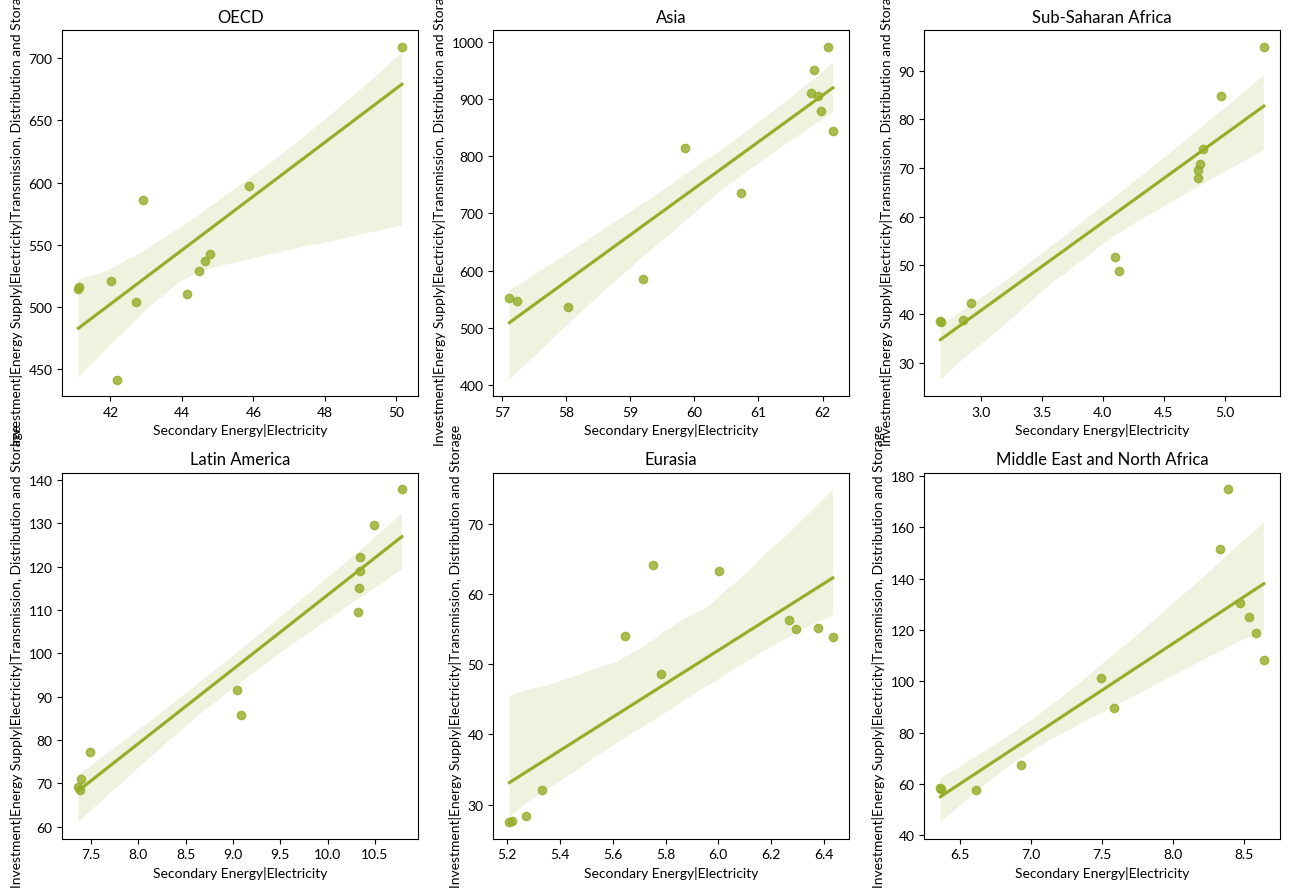

In [28]:
f, axes = plt.subplots(nrows=2,ncols=3,figsize=(13,9))

for count, ax in enumerate(axes.ravel()):
    sns.regplot(
        x = elec(),
        y = inv('Transmission, Distribution and Storage'),
        data = ar6_data.filter(
            variable=[inv('Transmission, Distribution and Storage'),elec()],
            model='REMIND**',
            year=2030,
            region=regions[count],
        )._data.droplevel('unit').unstack('variable').dropna(),
        ax=ax)

    ax.set_title(region_names[count])

plt.tight_layout()
                

In [29]:
def regression_format_investment(x_var,y_var):
    result = ar6_data.filter(
    variable=[x_var,y_var],
    year=2030,
    region=regions,
    model='REMIND*')
    
    output = (result
              ._data.droplevel('unit')
              .unstack('variable').dropna().groupby('region')
              .apply(lambda x:linregress(x[x_var],x[y_var]))
             )

    output = pd.concat(
        [output.apply(lambda x:x.slope),output.apply(lambda x:x.intercept)],axis=1)
    
    output.columns=['slope','intercept']
    return(output)


# regression_format_investment(elec(),inv('Transmission, Distribution and Storage'))

In [30]:
techs = ['Wind','Solar','Biomass','Hydro']
# test = ar6_data.copy()

for tech in techs[:]:
    for region in regions[:]:
        # print(f'{region}|{tech}')
        ar6_data.require_data(
        variable=inv(tech),
        region=region,
        exclude_on_fail=True)
    
    
        missing_data =(
            ar6_data
            .filter(exclude=True,variable=cap_add(tech),region=region)
            .timeseries()
            .multiply(regression_format_investment(cap_add(tech),inv(tech)).slope,axis='index')
            .add(regression_format_investment(cap_add(tech),inv(tech)).intercept,axis='index')
            .clip(lower=0)
            # .groupby(['region','variable']).median()
            .rename(index=lambda s:s.replace('Capacity Additions','Investment|Energy Supply').replace('GW/yr','billion USD_2010/yr'))
        )

        ar6_data = pyam.concat([ar6_data,missing_data])
        ar6_data.meta['exclude'] = False


pyam.core - INFO: 91 non-valid scenarios will be excluded
pyam.core - INFO: 90 non-valid scenarios will be excluded
pyam.core - INFO: 102 non-valid scenarios will be excluded
pyam.core - INFO: 100 non-valid scenarios will be excluded
pyam.core - INFO: 100 non-valid scenarios will be excluded
pyam.core - INFO: 100 non-valid scenarios will be excluded
pyam.core - INFO: 90 non-valid scenarios will be excluded
pyam.core - INFO: 91 non-valid scenarios will be excluded
pyam.core - INFO: 90 non-valid scenarios will be excluded
pyam.core - INFO: 102 non-valid scenarios will be excluded
pyam.core - INFO: 100 non-valid scenarios will be excluded
pyam.core - INFO: 100 non-valid scenarios will be excluded
pyam.core - INFO: 100 non-valid scenarios will be excluded
pyam.core - INFO: 90 non-valid scenarios will be excluded
pyam.core - INFO: 95 non-valid scenarios will be excluded
pyam.core - INFO: 94 non-valid scenarios will be excluded
pyam.core - INFO: 102 non-valid scenarios will be excluded
pyam.

In [31]:
techs = ['WnS','Renewables']
sub_techs = [['Wind','Solar'],['Wind','Solar','Hydro','Biomass']]
# test = ar6_data.copy()

for tech, sub_tech in dict(zip(techs,sub_techs)).items():
    for region in regions[:]:
        ar6_data.require_data(
        variable=inv(tech),
        region=region,
        exclude_on_fail=True)
    
    
        missing_data =assignlevel(
            ar6_data
            .filter(exclude=True,variable=[inv(x) for x in sub_tech],region=region)
            .timeseries()
            .groupby(['model','scenario','region','unit']).sum(),
            variable=inv(tech)
        ).reorder_levels(['model','scenario','region','variable','unit'])

        ar6_data = pyam.concat([ar6_data,missing_data])
        ar6_data.meta['exclude'] = False


pyam.core - INFO: 91 non-valid scenarios will be excluded
pyam.core - INFO: 90 non-valid scenarios will be excluded
pyam.core - INFO: 102 non-valid scenarios will be excluded
pyam.core - INFO: 100 non-valid scenarios will be excluded
pyam.core - INFO: 100 non-valid scenarios will be excluded
pyam.core - INFO: 100 non-valid scenarios will be excluded
pyam.core - INFO: 90 non-valid scenarios will be excluded
pyam.core - INFO: 95 non-valid scenarios will be excluded
pyam.core - INFO: 94 non-valid scenarios will be excluded
pyam.core - INFO: 102 non-valid scenarios will be excluded
pyam.core - INFO: 100 non-valid scenarios will be excluded
pyam.core - INFO: 100 non-valid scenarios will be excluded
pyam.core - INFO: 100 non-valid scenarios will be excluded
pyam.core - INFO: 94 non-valid scenarios will be excluded


In [32]:
tech = 'Transmission, Distribution and Storage'

ar6_data.require_data(
    variable=inv(tech),
    region=regions,
    exclude_on_fail=True)

missing_data =(
    ar6_data
    .filter(exclude=True,variable=elec(),region=regions)
    .timeseries()
    .multiply(regression_format_investment(elec(),inv(tech)).slope,axis='index')
    .add(regression_format_investment(elec(),inv(tech)).intercept,axis='index')
    .clip(lower=0)
    # .groupby(['region','variable']).median()
    .rename(index=lambda s:s.replace(elec(),inv(tech)).replace('EJ/yr','billion USD_2010/yr'))
)

ar6_data = pyam.concat([ar6_data,missing_data])
ar6_data.meta['exclude'] = False


pyam.core - INFO: 109 non-valid scenarios will be excluded


### Save processed AR6 data

In [33]:
ar6_data.to_csv('../data/processed/ar6_pathway_data.csv')
ar6_data.meta.to_csv('../data/processed/ar6_pathway_meta.csv')

## Historical capacity data
This is produced by the combination of Ember data (2000-2021), IRENA data (2022), and IEA estimates (2023) to give a timeseries from 2000-2023

### Load Ember data

In [9]:
ember_data = pd.read_csv('../data/raw/ember_globalelectricity_data.csv',
                        index_col=list(range(9)),
                         usecols=list(range(5))+list(range(11,16))
                        )
ember_capacity = projectlevel(
    formatlevel(
        ember_data.loc[
        isin(Category=['Capacity'],Variable=['Renewables','Wind and Solar','Wind','Solar','Hydro, Bioenergy and Other Renewables'])],
        Variable='{Category}|Electricity|{Variable}'),
    ['Country code','Year','Variable','Unit'])

ember_capacity.index.names=['region','year','variable','unit']
ember_capacity.rename(index={'Capacity|Electricity|Wind and Solar':'Capacity|Electricity|WnS',
                            'Capacity|Electricity|Hydro, Bioenergy and Other Renewables':'Capacity|Electricity|Renewables|Non-WnS'},inplace=True)
ember_capacity.head()

Value
region year variable                                unit       
AFG    2000 Capacity|Electricity|Renewables|Non-WnS GW     0.19
            Capacity|Electricity|Renewables         GW     0.19
            Capacity|Electricity|WnS                GW     0.00
            Capacity|Electricity|Solar              GW     0.00
            Capacity|Electricity|Wind               GW     0.00

Ember data is provided at the country level - need to add the regional groupings of interest

In [10]:
regional_ember = pd.DataFrame()

for region, countries in dict(zip(
    regions,
    [oecd_isos,asia_isos,africa_isos,latam_isos,ref_isos,mideast_isos])).items():

        regional_data = assignlevel(
            ember_capacity.loc[isin(region=countries)].groupby(['variable','unit','year']).sum().unstack('year'),
            region=region)

        regional_ember = pd.concat([regional_ember,regional_data])

regional_ember = regional_ember.reorder_levels(['region','variable','unit'])

ember_capacity = pd.concat([
    ember_capacity.reset_index().pivot_table(
        values='Value',
        index=['region','variable','unit'],
        columns='year'),
    regional_ember.droplevel(level=0,axis=1)])

ember_capacity.columns = list(range(2000,2023))
ember_capacity.head()

2000  2001  2002  2003  \
region variable                                unit                           
ABW    Capacity|Electricity|Renewables         GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|Renewables|Non-WnS GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|Solar              GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|Wind               GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|WnS                GW     0.0   0.0   0.0   0.0   

                                                     2004  2005  2006  2007  \
region variable                                unit                           
ABW    Capacity|Electricity|Renewables         GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|Renewables|Non-WnS GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|Solar              GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|Wind               GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|WnS                GW     0.0   0.0   0.0   0.0   

                                                     2008  2009  ...  2013  \
region variable                                unit              ...         
ABW    Capacity|Electricity|Renewables         GW     0.0  0.03  ...  0.03   
       Capacity|Electricity|Renewables|Non-WnS GW     0.0  0.00  ...  0.00   
       Capacity|Electricity|Solar              GW     0.0  0.00  ...  0.00   
       Capacity|Electricity|Wind               GW     0.0  0.03  ...  0.03   
       Capacity|Electricity|WnS                GW     0.0  0.03  ...  0.03   

                                                     2014  2015  2016  2017  \
region variable                                unit                           
ABW    Capacity|Electricity|Renewables         GW    0.03  0.04  0.04  0.04   
       Capacity|Electricity|Renewables|Non-WnS GW    0.00  0.00  0.00  0.00   
       Capacity|Electricity|Solar              GW    0.00  0.01  0.01  0.01   
       Capacity|Electricity|Wind               GW    0.03  0.03  0.03  0.03   
       Capacity|Electricity|WnS                GW    0.03  0.04  0.04  0.04   

                                                     2018  2019  2020  2021  \
region variable                                unit                           
ABW    Capacity|Electricity|Renewables         GW    0.04  0.04  0.04  0.04   
       Capacity|Electricity|Renewables|Non-WnS GW    0.00  0.00  0.00  0.00   
       Capacity|Electricity|Solar              GW    0.01  0.01  0.01  0.01   
       Capacity|Electricity|Wind               GW    0.03  0.03  0.03  0.03   
       Capacity|Electricity|WnS                GW    0.04  0.04  0.04  0.04   

                                                     2022  
region variable                                unit        
ABW    Capacity|Electricity|Renewables         GW     NaN  
       Capacity|Electricity|Renewables|Non-WnS GW     NaN  
       Capacity|Electricity|Solar              GW     NaN  
       Capacity|Electricity|Wind               GW     NaN  
       Capacity|Electricity|WnS                GW     NaN  

[5 rows x 23 columns]

### Load IRENA data
This will provide the 2022 values (as Ember data sometimes has missing values)

In [11]:
irena_data = pd.read_excel('../data/raw/IRENA_Stats_Tool.xlsb',sheet_name='Data',
                             skiprows=5,
                             index_col=list(range(10)),
                             usecols=range(12))

irena_data = irena_data.iloc[2:,:]

In [12]:
irena_data.index.names = ['macro_region','country_name','region','m49','renewable','tech_group','tech','tech_name','producer_type','year']
irena_data.columns = ['elec_gen','elec_cap']
irena_capacity = irena_data[['elec_cap']]
irena_generation = irena_data[['elec_gen']]

Again we need to aggregate country-level data together to provide the regional capacity results

In [13]:
regional_irena = pd.DataFrame()

for region, countries in dict(zip(
    regions,
    [oecd_isos,asia_isos,africa_isos,latam_isos,ref_isos,mideast_isos])).items():

        regional_data = assignlevel(
            irena_capacity.loc[ismatch(region=countries,renewable='Total Renewable',
                                   tech=['**Solar**','**wind**'])].groupby(['tech','year']).sum().unstack('year'),
            region=region)

        regional_irena = pd.concat([regional_irena,regional_data])

# regional_irena = regional_irena.reorder_levels(['region','tech_group'])


regional_irena

elec_cap                        
year                                       2020        2021        2022
tech                 region                                            
Offshore wind energy R5OECD           25015.899   26491.699     30188.2
Onshore wind energy  R5OECD          337427.784  367134.225  391354.979
Solar photovoltaic   R5OECD          330889.386  390574.142   453817.43
Solar thermal energy R5OECD            4073.074    3805.083    3805.083
Offshore wind energy R5ASIA              9353.2     27757.2       32435
Onshore wind energy  R5ASIA          318154.741  352106.193  387623.806
Solar photovoltaic   R5ASIA          341016.103   411738.46  519065.293
Solar thermal energy R5ASIA               893.5       917.5       943.5
Onshore wind energy  R10AFRICA         3444.653    4004.153    4231.153
Solar photovoltaic   R10AFRICA          7293.06      7968.3    8609.967
Solar thermal energy R10AFRICA              500         500         500
Onshore wind energy  R10LATIN_AM      33006.367   38908.943   42897.104
Solar photovoltaic   R10LATIN_AM      22664.022   32366.373   45978.715
Solar thermal energy R10LATIN_AM             17      125.27      125.27
Onshore wind energy  R10REF_ECON       3077.275    4669.325    5420.525
Solar photovoltaic   R10REF_ECON       9929.064   11254.592   11918.943
Onshore wind energy  R10MIDDLE_EAST     3993.27    4394.905    4508.765
Solar photovoltaic   R10MIDDLE_EAST    9766.767   12132.879   15641.589
Solar thermal energy R10MIDDLE_EAST     1028.61     1028.61      1228.5

In [14]:
regional_irena = pd.DataFrame()

for region, countries in dict(zip(
    regions,
    [oecd_isos,asia_isos,africa_isos,latam_isos,ref_isos,mideast_isos])).items():

        regional_data = assignlevel(
            irena_capacity.loc[isin(region=countries,renewable='Total Renewable')].groupby(['tech_group','year']).sum().unstack('year'),
            region=region)

        regional_irena = pd.concat([regional_irena,regional_data])

regional_irena = regional_irena.reorder_levels(['region','tech_group'])



irena_capacity = pd.concat([
    irena_capacity.loc[isin(renewable='Total Renewable')].unstack('year').groupby(['region','tech_group']).sum(),
    regional_irena])

irena_capacity

irena_capacity.columns = [2020,2021,2022]
irena_capacity = assignlevel(
    formatlevel(irena_capacity,variable='Capacity|Electricity|{tech_group}'),
    unit='GW')/1e3

irena_capacity = irena_capacity.droplevel('tech_group').reorder_levels(['region','variable','unit'])
irena_capacity.head()

2020  \
region variable                                           unit             
ABW    Capacity|Electricity|Bioenergy                     GW       0.002   
       Capacity|Electricity|Solar energy                  GW      0.0136   
       Capacity|Electricity|Wind energy                   GW        0.03   
AFG    Capacity|Electricity|Hydropower (excl. Pumped S... GW    0.348993   
       Capacity|Electricity|Solar energy                  GW    0.030833   

                                                                    2021  \
region variable                                           unit             
ABW    Capacity|Electricity|Bioenergy                     GW       0.002   
       Capacity|Electricity|Solar energy                  GW      0.0136   
       Capacity|Electricity|Wind energy                   GW        0.03   
AFG    Capacity|Electricity|Hydropower (excl. Pumped S... GW    0.356608   
       Capacity|Electricity|Solar energy                  GW    0.030662   

                                                                    2022  
region variable                                           unit            
ABW    Capacity|Electricity|Bioenergy                     GW       0.002  
       Capacity|Electricity|Solar energy                  GW      0.0136  
       Capacity|Electricity|Wind energy                   GW        0.03  
AFG    Capacity|Electricity|Hydropower (excl. Pumped S... GW    0.459138  
       Capacity|Electricity|Solar energy                  GW    0.032679

In [15]:
wns_irena = assignlevel(
    irena_capacity.loc[ismatch(variable=['**Wind**','**Solar**'])].groupby(['region','unit']).sum(),
    variable='Capacity|Electricity|WnS').reorder_levels(['region','variable','unit'])

total_capacity_irena = assignlevel(
    irena_capacity.groupby(['region','unit']).sum(),
    variable='Capacity|Electricity|Renewables').reorder_levels(['region','variable','unit'])

nonwns_irena = assignlevel(
    irena_capacity.loc[~ismatch(variable=['**Wind**','**Solar**'])].groupby(['region','unit']).sum(),
    variable='Capacity|Electricity|Renewables|Non-WnS').reorder_levels(['region','variable','unit'])


irena_capacity = pd.concat(
    [
        irena_capacity,
        wns_irena,
        nonwns_irena,
        total_capacity_irena
    ])

irena_capacity.sort_index(level='region',inplace=True)
irena_capacity.rename(index={'Capacity|Electricity|Wind energy':'Capacity|Electricity|Wind',
                            'Capacity|Electricity|Solar energy':'Capacity|Electricity|Solar'},inplace=True)
# ember_capacity.head()
irena_capacity.head(15)

2020  \
region variable                                           unit             
ABW    Capacity|Electricity|Bioenergy                     GW       0.002   
       Capacity|Electricity|Renewables                    GW      0.0456   
       Capacity|Electricity|Renewables|Non-WnS            GW       0.002   
       Capacity|Electricity|Solar                         GW      0.0136   
       Capacity|Electricity|Wind                          GW        0.03   
       Capacity|Electricity|WnS                           GW      0.0436   
AFG    Capacity|Electricity|Hydropower (excl. Pumped S... GW    0.348993   
       Capacity|Electricity|Renewables                    GW    0.380226   
       Capacity|Electricity|Renewables|Non-WnS            GW    0.348993   
       Capacity|Electricity|Solar                         GW    0.030833   
       Capacity|Electricity|Wind                          GW      0.0004   
       Capacity|Electricity|WnS                           GW    0.031233   
AGO    Capacity|Electricity|Bioenergy                     GW       0.051   
       Capacity|Electricity|Hydropower (excl. Pumped S... GW    3.729279   
       Capacity|Electricity|Renewables                    GW    3.781668   

                                                                    2021  \
region variable                                           unit             
ABW    Capacity|Electricity|Bioenergy                     GW       0.002   
       Capacity|Electricity|Renewables                    GW      0.0456   
       Capacity|Electricity|Renewables|Non-WnS            GW       0.002   
       Capacity|Electricity|Solar                         GW      0.0136   
       Capacity|Electricity|Wind                          GW        0.03   
       Capacity|Electricity|WnS                           GW      0.0436   
AFG    Capacity|Electricity|Hydropower (excl. Pumped S... GW    0.356608   
       Capacity|Electricity|Renewables                    GW     0.38767   
       Capacity|Electricity|Renewables|Non-WnS            GW    0.356608   
       Capacity|Electricity|Solar                         GW    0.030662   
       Capacity|Electricity|Wind                          GW      0.0004   
       Capacity|Electricity|WnS                           GW    0.031062   
AGO    Capacity|Electricity|Bioenergy                     GW       0.051   
       Capacity|Electricity|Hydropower (excl. Pumped S... GW    3.729279   
       Capacity|Electricity|Renewables                    GW    3.781736   

                                                                    2022  
region variable                                           unit            
ABW    Capacity|Electricity|Bioenergy                     GW       0.002  
       Capacity|Electricity|Renewables                    GW      0.0456  
       Capacity|Electricity|Renewables|Non-WnS            GW       0.002  
       Capacity|Electricity|Solar                         GW      0.0136  
       Capacity|Electricity|Wind                          GW        0.03  
       Capacity|Electricity|WnS                           GW      0.0436  
AFG    Capacity|Electricity|Hydropower (excl. Pumped S... GW    0.459138  
       Capacity|Electricity|Renewables                    GW    0.492217  
       Capacity|Electricity|Renewables|Non-WnS            GW    0.459138  
       Capacity|Electricity|Solar                         GW    0.032679  
       Capacity|Electricity|Wind                          GW      0.0004  
       Capacity|Electricity|WnS                           GW    0.033079  
AGO    Capacity|Electricity|Bioenergy                     GW       0.051  
       Capacity|Electricity|Hydropower (excl. Pumped S... GW    3.729279  
       Capacity|Electricity|Renewables                    GW    4.065736

### Merge IRENA and Ember data to give a unified timeseries out to 2022

In [16]:
cap_hist = pd.concat(
    [
        ember_capacity.loc[:,:2021],
        irena_capacity.loc[ismatch(variable=['**Renewables','**WnS','**Wind','**Solar']),2022]
    ],
axis=1)

cap_hist = pd.concat(
    [
        cap_hist,
        pd.concat({'World': cap_hist.loc[ismatch(region=regions)].groupby(['variable','unit']).sum()}, names=['region']),
        pd.concat({'EU27': cap_hist.loc[ismatch(region=eu27_isos)].groupby(['variable','unit']).sum()}, names=['region'])
    ])
cap_hist.head()

2000  2001  2002  2003  \
region variable                                unit                           
ABW    Capacity|Electricity|Renewables         GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|Renewables|Non-WnS GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|Solar              GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|Wind               GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|WnS                GW     0.0   0.0   0.0   0.0   

                                                     2004  2005  2006  2007  \
region variable                                unit                           
ABW    Capacity|Electricity|Renewables         GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|Renewables|Non-WnS GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|Solar              GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|Wind               GW     0.0   0.0   0.0   0.0   
       Capacity|Electricity|WnS                GW     0.0   0.0   0.0   0.0   

                                                     2008  2009  ...  2013  \
region variable                                unit              ...         
ABW    Capacity|Electricity|Renewables         GW     0.0  0.03  ...  0.03   
       Capacity|Electricity|Renewables|Non-WnS GW     0.0  0.00  ...  0.00   
       Capacity|Electricity|Solar              GW     0.0  0.00  ...  0.00   
       Capacity|Electricity|Wind               GW     0.0  0.03  ...  0.03   
       Capacity|Electricity|WnS                GW     0.0  0.03  ...  0.03   

                                                     2014  2015  2016  2017  \
region variable                                unit                           
ABW    Capacity|Electricity|Renewables         GW    0.03  0.04  0.04  0.04   
       Capacity|Electricity|Renewables|Non-WnS GW    0.00  0.00  0.00  0.00   
       Capacity|Electricity|Solar              GW    0.00  0.01  0.01  0.01   
       Capacity|Electricity|Wind               GW    0.03  0.03  0.03  0.03   
       Capacity|Electricity|WnS                GW    0.03  0.04  0.04  0.04   

                                                     2018  2019  2020  2021  \
region variable                                unit                           
ABW    Capacity|Electricity|Renewables         GW    0.04  0.04  0.04  0.04   
       Capacity|Electricity|Renewables|Non-WnS GW    0.00  0.00  0.00  0.00   
       Capacity|Electricity|Solar              GW    0.01  0.01  0.01  0.01   
       Capacity|Electricity|Wind               GW    0.03  0.03  0.03  0.03   
       Capacity|Electricity|WnS                GW    0.04  0.04  0.04  0.04   

                                                       2022  
region variable                                unit          
ABW    Capacity|Electricity|Renewables         GW    0.0456  
       Capacity|Electricity|Renewables|Non-WnS GW     0.002  
       Capacity|Electricity|Solar              GW    0.0136  
       Capacity|Electricity|Wind               GW      0.03  
       Capacity|Electricity|WnS                GW    0.0436  

[5 rows x 23 columns]

### Add 2023 estimates in
We have 2023 estimates of renewable capacity installations, which come from merging together two IEA reports:
- https://www.iea.org/data-and-statistics/data-tools/renewables-data-explorer. This gives a country-level forecast of renewables installation as of Dec 2022). Globally this reaches 350/400 GW installed in 2023 in a central/accelerated case
- https://www.iea.org/reports/renewable-energy-market-update-june-2023. This gives a global forecast of 450/500 GW installed globally in 2023 in the central/accelerated case, with a breakdown provided only for China (230 GW in the central case).

We assume that in 2023, 500 GW will be installed (take the accelerated case from the IEA's 2023 report). To provide the country breakdown, we take the IEA's 2023 estimates for China (that ~230 GW of renewables will be installed in China), and then scale all other countries from the IEA's 2022 report to give the 2023 global average. I.e. we assume that the uptick in action is distributed globally, with a concentration in China

#### Load and process IEA renewables data

In [15]:
iea_renewables = pd.read_excel('../data/raw/REMR2023_Databook.xlsx',
                         usecols=[3,4,5,6,8,9,11],
                        index_col=list(range(6))
                        )
iea_renewables.index.names = ['region','year','code_product','production','flow','scenario']
iea_renewables = iea_renewables.unstack('year')
iea_renewables.columns = range(1990,2029)
iea_renewables

1990  \
region code_product production                                         flow               scenario             
Africa BIO          Bioenergy                                          Capacity (GW)      ACC       0.601576   
                                                                                          MAIN      0.601576   
                                                                       Generation (TWH)   MAIN      0.445000   
                                                                       Net additions (GW) ACC            NaN   
                                                                                          MAIN           NaN   
...                                                                                                      ...   
World  WINDPOWER    Wind energy dedicated to power generation for f... Capacity (GW)      ACC       2.368981   
                                                                                          MAIN      2.368981   
                                                                       Generation (TWH)   MAIN      3.880372   
                                                                       Net additions (GW) ACC            NaN   
                                                                                          MAIN           NaN   

                                                                                                        1991  \
region code_product production                                         flow               scenario             
Africa BIO          Bioenergy                                          Capacity (GW)      ACC       0.605576   
                                                                                          MAIN      0.605576   
                                                                       Generation (TWH)   MAIN      0.483000   
                                                                       Net additions (GW) ACC       0.004000   
                                                                                          MAIN      0.004000   
...                                                                                                      ...   
World  WINDPOWER    Wind energy dedicated to power generation for f... Capacity (GW)      ACC       2.606859   
                                                                                          MAIN      2.606859   
                                                                       Generation (TWH)   MAIN      4.197618   
                                                                       Net additions (GW) ACC       0.237878   
                                                                                          MAIN      0.237878   

                                                                                                        1992  \
region code_product production                                         flow               scenario             
Africa BIO          Bioenergy                                          Capacity (GW)      ACC       0.614576   
                                                                                          MAIN      0.614576   
                                                                       Generation (TWH)   MAIN      0.619000   
                                                                       Net additions (GW) ACC       0.009000   
                                                                                          MAIN      0.009000   
...                                                                                                      ...   
World  WINDPOWER    Wind energy dedicated to power generation for f... Capacity (GW)      ACC       2.698449   
                                                                                          MAIN      2.698449   
                                                                      

In [16]:
def name_to_iso(name):
    if pycountry.countries.get(name=name) is None:
        return name
    else:
        return  pycountry.countries.get(name=name).alpha_3


In [17]:
iea_renewables.rename(index=lambda s:s
                             .replace("Korea","Korea, Republic of")
                             .replace('Türkiye','Turkey')
                             .replace('United Republic Of Tanzania','Tanzania,United Republic of')
                             .replace('European Union','EU27')
                             .replace('Middle East and North Africa','R10MIDDLE_EAST')
                             .replace('Sub-Saharan Africa','R10AFRICA')
                             .replace('Eurasia','R10REF_ECON')
                             .replace('Latin America','R10LATIN_AM')
                             .replace('Total','Renewables'),
               inplace=True)

iea_renewables = assignlevel(
    iea_renewables,
    region=projectlevel(iea_renewables,'region').index.map(lambda name:name_to_iso(name)),
)

iea_renewables

1990  \
region code_product production                                         flow               scenario             
Africa BIO          Bioenergy                                          Capacity (GW)      ACC       0.601576   
                                                                                          MAIN      0.601576   
                                                                       Generation (TWH)   MAIN      0.445000   
                                                                       Net additions (GW) ACC            NaN   
                                                                                          MAIN           NaN   
...                                                                                                      ...   
World  WINDPOWER    Wind energy dedicated to power generation for f... Capacity (GW)      ACC       2.368981   
                                                                                          MAIN      2.368981   
                                                                       Generation (TWH)   MAIN      3.880372   
                                                                       Net additions (GW) ACC            NaN   
                                                                                          MAIN           NaN   

                                                                                                        1991  \
region code_product production                                         flow               scenario             
Africa BIO          Bioenergy                                          Capacity (GW)      ACC       0.605576   
                                                                                          MAIN      0.605576   
                                                                       Generation (TWH)   MAIN      0.483000   
                                                                       Net additions (GW) ACC       0.004000   
                                                                                          MAIN      0.004000   
...                                                                                                      ...   
World  WINDPOWER    Wind energy dedicated to power generation for f... Capacity (GW)      ACC       2.606859   
                                                                                          MAIN      2.606859   
                                                                       Generation (TWH)   MAIN      4.197618   
                                                                       Net additions (GW) ACC       0.237878   
                                                                                          MAIN      0.237878   

                                                                                                        1992  \
region code_product production                                         flow               scenario             
Africa BIO          Bioenergy                                          Capacity (GW)      ACC       0.614576   
                                                                                          MAIN      0.614576   
                                                                       Generation (TWH)   MAIN      0.619000   
                                                                       Net additions (GW) ACC       0.009000   
                                                                                          MAIN      0.009000   
...                                                                                                      ...   
World  WINDPOWER    Wind energy dedicated to power generation for f... Capacity (GW)      ACC       2.698449   
                                                                                          MAIN      2.698449   
                                                                      

##### Focus on the capacity additions of renewables

In [20]:
cap_add_iea = formatlevel(
    iea_renewables.loc[isin(
        flow='Net additions (GW)',
        code_product=['PV','TOTAL','WIND'])],
    variable='Capacity Additions|Electricity|{production}')

cap_add_iea = cap_add_iea.droplevel(['code_product','production','flow'])
cap_add_iea = cap_add_iea.reorder_levels(['region','scenario','variable'])
cap_add_iea = cap_add_iea.rename(index=lambda s:s.replace(' PV',''))


cap_add_iea = pd.concat(
    [
        cap_add_iea,
        assignlevel(
            cap_add_iea.loc[ismatch(variable=['**Solar','**Wind'])]
            .groupby(['region','scenario']).sum(),
            variable=cap_add('WnS')),
    ])


cap_add_iea = pd.concat(
    [
        cap_add_iea,
        assignlevel(
            cap_add_iea.loc[isin(variable=cap_add('Renewables'))]
            .subtract(cap_add_iea.loc[isin(variable=cap_add('WnS'))].droplevel('variable')),
            variable=cap_add('Renewables|Non-WnS')
        )
    ])


cap_add_iea = pd.concat(
    [
        cap_add_iea,
        pd.concat([
            assignlevel(
                cap_add_iea.loc[isin(variable=cap_add(tech),region=oecd_isos)].groupby(['variable','scenario']).sum(),
                region='R5OECD'
            ) for tech in ['Renewables','Solar','Wind','WnS','Renewables|Non-WnS']
        ]).reorder_levels([2,1,0]),
        pd.concat([
            assignlevel(
                cap_add_iea.loc[isin(variable=cap_add(tech),region=asia_isos)].groupby(['variable','scenario']).sum(),
                region='R5ASIA'
            ) for tech in ['Renewables','Solar','Wind','WnS','Renewables|Non-WnS']
        ]).reorder_levels([2,1,0])
    ])

cap_add_iea

1990  \
region scenario variable                                                  
Africa ACC      Capacity Additions|Electricity|Solar                NaN   
       MAIN     Capacity Additions|Electricity|Solar                NaN   
       ACC      Capacity Additions|Electricity|Renewables           NaN   
       MAIN     Capacity Additions|Electricity|Renewables           NaN   
       ACC      Capacity Additions|Electricity|Wind                 NaN   
...                                                                 ...   
R5ASIA MAIN     Capacity Additions|Electricity|Wind                 0.0   
       ACC      Capacity Additions|Electricity|WnS                  0.0   
       MAIN     Capacity Additions|Electricity|WnS                  0.0   
       ACC      Capacity Additions|Electricity|Renewables|Non-WnS   0.0   
       MAIN     Capacity Additions|Electricity|Renewables|Non-WnS   0.0   

                                                                       1991  \
region scenario variable                                                      
Africa ACC      Capacity Additions|Electricity|Solar               0.000000   
       MAIN     Capacity Additions|Electricity|Solar               0.000000   
       ACC      Capacity Additions|Electricity|Renewables          0.136555   
       MAIN     Capacity Additions|Electricity|Renewables          0.136555   
       ACC      Capacity Additions|Electricity|Wind                0.000000   
...                                                                     ...   
R5ASIA MAIN     Capacity Additions|Electricity|Wind                0.000000   
       ACC      Capacity Additions|Electricity|WnS                 0.000000   
       MAIN     Capacity Additions|Electricity|WnS                 0.000000   
       ACC      Capacity Additions|Electricity|Renewables|Non-WnS  1.712761   
       MAIN     Capacity Additions|Electricity|Renewables|Non-WnS  1.712761   

                                                                       1992  \
region scenario variable                                                      
Africa ACC      Capacity Additions|Electricity|Solar               0.000000   
       MAIN     Capacity Additions|Electricity|Solar               0.000000   
       ACC      Capacity Additions|Electricity|Renewables          0.030389   
       MAIN     Capacity Additions|Electricity|Renewables          0.030389   
       ACC      Capacity Additions|Electricity|Wind                0.000000   
...                                                                     ...   
R5ASIA MAIN     Capacity Additions|Electricity|Wind                0.000000   
       ACC      Capacity Additions|Electricity|WnS                 0.000000   
       MAIN     Capacity Additions|Electricity|WnS                 0.000000   
       ACC      Capacity Additions|Electricity|Renewables|Non-WnS  3.809332   
       MAIN     Capacity Additions|Electricity|Renewables|Non-WnS  3.809332   

                                                                       1993  \
region scenario variable                                                      
Africa ACC      Capacity Additions|Electricity|Solar               0.000000   
       MAIN     Capacity Additions|Electricity|Solar               0.000000   
       ACC      Capacity Additions|Electricity|Renewables          0.119840   
       MAIN     Capacity Additions|Electricity|Renewables          0.119840   
       ACC      Capacity Additions|Electricity|Wind                0.000000   
...                                                                     ...   
R5ASIA MAIN     Capacity Additions|Electricity|Wind                0.000000   
       ACC      Capacity Additions|Electricity|WnS                 0.001000   
       MAIN     Capacity Additions|Electricity|WnS                 0.001000   
       ACC      Capacity Additions|Electricity|Renewables|Non-WnS  5.472945   
       MAIN     Capacity Additions|Electricity|Renewables|Non-WnS  5.472945   

       

In [29]:
cap_hist.loc[isin(region='R5ASIA'),2021:].diff(axis=1)

2021        2022
region variable                                unit                  
R5ASIA Capacity|Electricity|Renewables         GW     NaN  180.524477
       Capacity|Electricity|Renewables|Non-WnS GW     NaN   32.946878
       Capacity|Electricity|Solar              GW     NaN  107.368793
       Capacity|Electricity|Wind               GW     NaN   40.208806
       Capacity|Electricity|WnS                GW     NaN  147.577599

In [31]:
projectlevel(
    cap_add_iea.loc[isin(region=asia_isos),2022],
    'region').index.unique()

Index(['CHN', 'IND', 'IDN', 'KOR', 'PAK', 'PHL', 'THA', 'VNM'], dtype='object', name='region')

In [33]:
data_coverage = pd.DataFrame(index=regions[:-1],columns=[cap_add(tech) for tech in ['Renewables','Wind','Solar','WnS','Renewables|Non-WnS']])

for region, countries in zip(regions[:-1],isos[:-1]):
    for tech in ['Renewables','Wind','Solar','WnS','Renewables|Non-WnS']:
        iea_coverage = cap_hist.loc[
        isin(
            region=projectlevel(cap_add_iea.loc[isin(region=countries,variable=cap_add(tech)),2023],'region').index.unique(),
            variable=cap(tech)),2022].sum()
    
        total_capacity = cap_hist.loc[isin(
            region=region,
            variable=cap(tech)),
        2022].sum()
    
        data_coverage.loc[region,cap_add(tech)] = (iea_coverage/total_capacity)
    
    

data_coverage = pd.concat([
    assignlevel(data_coverage,scenario='ACC'),
    assignlevel(data_coverage,scenario='MAIN'),
]).stack()

data_coverage.index.names = ['region','scenario','variable']

data_coverage.loc[~ismatch(region=['R5OECD','R5ASIA'])] = 1 #Only scaling for R5OECD, where the country sums we have don't cover all OECD countries (Asia has 96% coverage already)

In [45]:
data_coverage

region          scenario  variable                                         
R5OECD          ACC       Capacity Additions|Electricity|Renewables            0.862737
                          Capacity Additions|Electricity|Wind                   0.90945
                          Capacity Additions|Electricity|Solar                 0.934147
                          Capacity Additions|Electricity|WnS                   0.922305
                          Capacity Additions|Electricity|Renewables|Non-WnS    0.758689
R5ASIA          ACC       Capacity Additions|Electricity|Renewables            0.963986
                          Capacity Additions|Electricity|Wind                  0.995118
                          Capacity Additions|Electricity|Solar                 0.971179
                          Capacity Additions|Electricity|WnS                   0.981876
                          Capacity Additions|Electricity|Renewables|Non-WnS    0.933989
R10AFRICA       ACC       Capacity Additions

In [34]:
cap_add_iea.loc[isin(region=regions[:-1]),2023:] = (
    cap_add_iea.loc[
    isin(
        region=regions[:-1],
        variable=[cap_add(tech) for tech in ['Renewables','Wind','Solar','WnS','Renewables|Non-WnS']]),
    2023:
].divide(data_coverage,axis=0)
)

In [35]:
cap_add_main = (
    cap_add_iea
    .loc[isin(scenario='MAIN'),2023:]
    .cumsum(axis=1)
    .droplevel('scenario')
)

cap_add_accelerated = (
    cap_add_iea
    .loc[isin(scenario='ACC'),2023:]
    .cumsum(axis=1)
    .droplevel('scenario')
)

In [ ]:
cap_future.loc[isin(
    region=['R10MIDDLE_EAST']+mideast_isos,
    variable=cap('Renewables')),
    2023]

In [44]:
cap_future.loc[isin(
    region=['R10AFRICA']+africa_isos,
    variable=cap('Renewables')),
    2023].dropna()

region     variable                         unit
ETH        Capacity|Electricity|Renewables  GW        6.84958
KEN        Capacity|Electricity|Renewables  GW       2.800388
NGA        Capacity|Electricity|Renewables  GW       3.093804
ZAF        Capacity|Electricity|Renewables  GW      13.884339
R10AFRICA  Capacity|Electricity|Renewables  GW       52.89104
Name: 2023, dtype: object

#### Add IEA data to the timeseries

In [36]:
cap_hist[2023] = cap_hist[2022] + cap_add_main.rename(index=lambda s:s.replace(' Additions',''))[2023]
cap_hist_accelerated = cap_hist.copy()

cap_hist_accelerated[2023] = (
    cap_hist_accelerated[2022] 
    + cap_add_accelerated.rename(index=lambda s:s.replace(' Additions',''))[2023]
)

cap_hist_data = pd.concat([
    assignlevel(cap_hist,scenario='Main'),
    assignlevel(cap_hist_accelerated,scenario='Accelerated')
]).reorder_levels(['region','scenario','variable','unit'])


In [37]:
cap_future = cap_hist.copy()
for year in range(2024,2029):
    cap_future[year] = (
        cap_future[2022] 
        + cap_add_main.rename(index=lambda s:s.replace(' Additions',''))[year]
    )
    
cap_future_accelerated = cap_hist_accelerated.copy()
for year in range(2024,2029):
    cap_future_accelerated[year] = (
        cap_future_accelerated[2022] 
        + cap_add_accelerated.rename(index=lambda s:s.replace(' Additions',''))[year]
    )


cap_future_data = pd.concat([
    assignlevel(cap_future_accelerated,scenario='Accelerated'),
    assignlevel(cap_future,scenario='Main')
]).reorder_levels(['region','scenario','variable','unit'])

In [38]:
cap_hist_data.to_csv('../data/processed/capacity_historic.csv')
cap_future_data.to_csv('../data/processed/capacity_iea_forecasts.csv')

## Historical generation data
ToDo: Update to not drop individual countries when producing the regional dataframe

### Load Ember data

In [9]:
ember_data = pd.read_csv('../data/raw/ember_globalelectricity_data.csv',
                        index_col=list(range(9)),
                         usecols=list(range(5))+list(range(11,16))
                        )
ember_generation = projectlevel(
    formatlevel(
        ember_data.loc[isin(Category='Electricity generation',Variable=['Renewables','Wind and Solar'],Unit='TWh')],
        Variable='{Category}|{Variable}'),
    ['Country code','Year','Variable','Unit'])

ember_generation.index.names=['region','year','variable','unit']
ember_generation.head()

Value
region year variable                              unit       
AFG    2000 Electricity generation|Renewables     TWh    0.31
            Electricity generation|Wind and Solar TWh    0.00
       2001 Electricity generation|Renewables     TWh    0.50
            Electricity generation|Wind and Solar TWh    0.00
       2002 Electricity generation|Renewables     TWh    0.56

In [13]:
gen_hist = pd.DataFrame()

for region, countries in dict(zip(
    regions,
    [oecd_isos,asia_isos,africa_isos,latam_isos,ref_isos,mideast_isos,world_isos])).items():

        regional_data = assignlevel(
            ember_generation.loc[isin(region=countries)].groupby(['variable','unit','year']).sum().unstack('year'),
            region=region)

        gen_hist = pd.concat([gen_hist,regional_data])


gen_hist.rename(index=lambda s:s.replace('Electricity generation','Secondary Energy|Electricity'),inplace=True)
gen_hist = gen_hist.reorder_levels(['region','variable','unit'])
gen_hist.columns = list(range(2000,2023))
gen_hist.head()

2000     2001  \
region    variable                                    unit                     
R5OECD    Secondary Energy|Electricity|Renewables     TWh   1513.20  1416.74   
          Secondary Energy|Electricity|Wind and Solar TWh     29.51    35.86   
R5ASIA    Secondary Energy|Electricity|Renewables     TWh    426.13   484.57   
          Secondary Energy|Electricity|Wind and Solar TWh      2.24     2.90   
R10AFRICA Secondary Energy|Electricity|Renewables     TWh     61.42    66.46   

                                                               2002     2003  \
region    variable                                    unit                     
R5OECD    Secondary Energy|Electricity|Renewables     TWh   1463.21  1460.86   
          Secondary Energy|Electricity|Wind and Solar TWh     49.90    60.55   
R5ASIA    Secondary Energy|Electricity|Renewables     TWh    491.99   498.32   
          Secondary Energy|Electricity|Wind and Solar TWh      3.05     3.75   
R10AFRICA Secondary Energy|Electricity|Renewables     TWh     70.83    68.40   

                                                               2004     2005  \
region    variable                                    unit                     
R5OECD    Secondary Energy|Electricity|Renewables     TWh   1528.49  1573.33   
          Secondary Energy|Electricity|Wind and Solar TWh     80.11    98.54   
R5ASIA    Secondary Energy|Electricity|Renewables     TWh    603.51   657.28   
          Secondary Energy|Electricity|Wind and Solar TWh      6.72     8.32   
R10AFRICA Secondary Energy|Electricity|Renewables     TWh     74.02    76.95   

                                                               2006     2007  \
region    variable                                    unit                     
R5OECD    Secondary Energy|Electricity|Renewables     TWh   1618.46  1624.10   
          Secondary Energy|Electricity|Wind and Solar TWh    122.85   157.32   
R5ASIA    Secondary Energy|Electricity|Renewables     TWh    730.20   803.48   
          Secondary Energy|Electricity|Wind and Solar TWh     13.80    18.38   
R10AFRICA Secondary Energy|Electricity|Renewables     TWh     79.93    79.36   

                                                               2008     2009  \
region    variable                                    unit                     
R5OECD    Secondary Energy|Electricity|Renewables     TWh   1718.97  1779.84   
          Secondary Energy|Electricity|Wind and Solar TWh    199.81   244.71   
R5ASIA    Secondary Energy|Electricity|Renewables     TWh    974.32   972.21   
          Secondary Energy|Electricity|Wind and Solar TWh     29.17    46.51   
R10AFRICA Secondary Energy|Electricity|Renewables     TWh     82.08    84.11   

                                                            ...     2013  \
region    variable                                    unit  ...            
R5OECD    Secondary Energy|Electricity|Renewables     TWh   ...  2268.60   
          Secondary Energy|Electricity|Wind and Solar TWh   ...   563.38   
R5ASIA    Secondary Energy|Electricity|Renewables     TWh   ...  1534.78   
          Secondary Energy|Electricity|Wind and Solar TWh   ...   187.79   
R10AFRICA Secondary Energy|Electricity|Renewables     TWh   ...    97.49   

                                                               2014     2015  \
region    variable                                    unit                     
R5OECD    Secondary Energy|Electricity|Renewables     TWh   2331.22  2442.74   
          Secondary Energy|Electricity|Wind and Solar TWh    644.93   747.15   
R5ASIA    Secondary Energy|Electricity|Renewables     TWh   1750.21  1855.15   
          Secondary Energy|Electricity|Wind and Solar TWh    231.97   278.32   
R10AFRICA Secondary Energy|Electricity|Renewables     TWh    107.02   110.24   

                                                               2016     2017  \
region    variable                                    unit                     
R5OE

<Axes: >

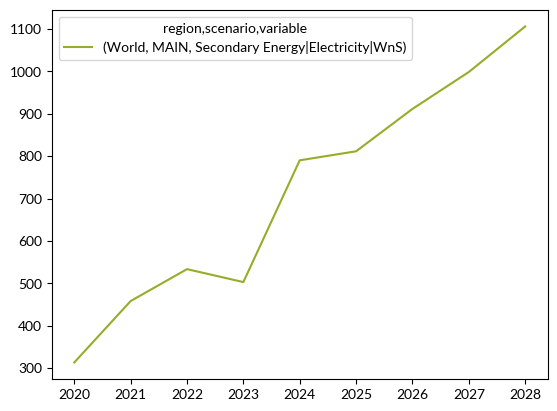

In [28]:
gen_add_iea = formatlevel(
    iea_renewables.loc[isin(
        flow='Generation (TWH)',
        code_product=['PV','TOTAL','WIND'])],
    variable='Secondary Energy|Electricity|{production}')

gen_add_iea = gen_add_iea.droplevel(['code_product','production','flow'])
gen_add_iea = gen_add_iea.reorder_levels(['region','scenario','variable'])
gen_add_iea = gen_add_iea.rename(index=lambda s:s.replace(' PV',''))


gen_add_iea = pd.concat(
    [
        gen_add_iea,
        assignlevel(
            gen_add_iea.loc[ismatch(variable=['**Solar','**Wind'])]
            .groupby(['region','scenario']).sum(),
            variable=elec('WnS')),
    ])

gen_add_iea.loc[isin(region='World',variable=elec('WnS')),2019:].diff(axis=1).T.plot()

In [14]:
gen_hist.loc[isin(region='World')]

2000     2001  \
region variable                                    unit                     
World  Secondary Energy|Electricity|Renewables     TWh   2851.44  2792.61   
       Secondary Energy|Electricity|Wind and Solar TWh     32.31    39.62   

                                                            2002     2003  \
region variable                                    unit                     
World  Secondary Energy|Electricity|Renewables     TWh   2863.53  2889.47   
       Secondary Energy|Electricity|Wind and Solar TWh     53.93    65.55   

                                                            2004     2005  \
region variable                                    unit                     
World  Secondary Energy|Electricity|Renewables     TWh   3124.06  3272.31   
       Secondary Energy|Electricity|Wind and Solar TWh     88.29   108.40   

                                                            2006     2007  \
region variable                                    unit                     
World  Secondary Energy|Electricity|Renewables     TWh   3421.88  3529.48   
       Secondary Energy|Electricity|Wind and Solar TWh    138.54   178.49   

                                                            2008     2009  \
region variable                                    unit                     
World  Secondary Energy|Electricity|Renewables     TWh   3787.71  3867.94   
       Secondary Energy|Electricity|Wind and Solar TWh    232.13   295.93   

                                                         ...     2013  \
region variable                                    unit  ...            
World  Secondary Energy|Electricity|Renewables     TWh   ...  5019.08   
       Secondary Energy|Electricity|Wind and Solar TWh   ...   772.66   

                                                            2014     2015  \
region variable                                    unit                     
World  Secondary Energy|Electricity|Renewables     TWh   5282.07  5505.27   
       Secondary Energy|Electricity|Wind and Solar TWh    913.68  1084.18   

                                                            2016     2017  \
region variable                                    unit                     
World  Secondary Energy|Electricity|Renewables     TWh   5844.90  6220.22   
       Secondary Energy|Electricity|Wind and Solar TWh   1286.13  1580.26   

                                                            2018     2019  \
region variable                                    unit                     
World  Secondary Energy|Electricity|Renewables     TWh   6643.14  6990.30   
       Secondary Energy|Electricity|Wind and Solar TWh   1839.31  2120.68   

                                                            2020     2021  \
region variable                                    unit                     
World  Secondary Energy|Electricity|Renewables     TWh   7467.95  7892.32   
       Secondary Energy|Electricity|Wind and Solar TWh   2435.68  2896.21   

                                                            2022  
region variable                                    unit           
World  Secondary Energy|Electricity|Renewables     TWh   8020.00  
       Secondary Energy|Electricity|Wind and Solar TWh   3367.29  

[2 rows x 23 columns]

In [54]:
# wns_irena = assignlevel(
#     regional_irena.loc[ismatch(variable=['**Wind**','**Solar**'])].groupby(['region','unit']).sum(),
#     variable='Capacity|Electricity|WnS').reorder_levels(['region','variable','unit'])

# total_capacity_irena = assignlevel(
#     regional_irena.groupby(['region','unit']).sum(),
#     variable='Capacity|Electricity|Renewables').reorder_levels(['region','variable','unit'])

# regional_irena = pd.concat(
#     [
#         regional_irena,
#         wns_irena,
#         total_capacity_irena
#     ])

# regional_irena.sort_index(level='region',inplace=True)
# regional_irena.head()

### Calculate growth rates

In [55]:
gr_gen_hist = pd.concat(
    [
        ((gen_hist.shift(-time_period,axis=1)/gen_hist)**(1/time_period)).dropna(axis=1).iloc[:,-2]
        for time_period in [1,5,10]
    ],
axis=1)

gr_gen_hist = (gr_gen_hist-1)*1e2
gr_gen_hist.columns = ['2020-21','2016-21','2011-21']
gr_gen_hist = gr_gen_hist[['2011-21','2016-21','2020-21']]

gr_gen_hist = assignlevel(
    gr_gen_hist.rename(
        index=lambda s:s.replace('Secondary Energy|Electricity','Generation Growth Rate')),
    unit='%')

gr_gen_hist.head()

2011-21    2016-21  \
region    variable                              unit                         
R5OECD    Generation Growth Rate|Renewables     %      4.716116   4.510169   
          Generation Growth Rate|Wind and Solar %     13.966354  11.728843   
R5ASIA    Generation Growth Rate|Renewables     %     10.575087   9.705244   
          Generation Growth Rate|Wind and Solar %     27.617005  25.915926   
R10AFRICA Generation Growth Rate|Renewables     %      4.700664   5.635124   

                                                        2020-21  
region    variable                              unit             
R5OECD    Generation Growth Rate|Renewables     %      2.503810  
          Generation Growth Rate|Wind and Solar %      8.465104  
R5ASIA    Generation Growth Rate|Renewables     %     11.039033  
          Generation Growth Rate|Wind and Solar %     32.850933  
R10AFRICA Generation Growth Rate|Renewables     %      3.991876

## 2022 wind and solar breakdown in regions

In [56]:
wns_capacity = irena_data[['elec_cap']]
wns_capacity = wns_capacity.loc[ismatch(renewable='Total Renewable',
                                   tech=['**Solar ph**','**wind**'],
                                      year=2022)].groupby(['region','tech']).sum()

In [57]:
regional_wns_data = pd.DataFrame()

for region, countries in dict(zip(
    regions,
    [oecd_isos,asia_isos,africa_isos,latam_isos,ref_isos,mideast_isos])).items():

        regional_data = assignlevel(
            wns_capacity.loc[ismatch(region=countries)].groupby('tech').sum(),
            region=region)

        regional_wns_data = pd.concat([regional_wns_data,regional_data])

regional_wns_data = regional_wns_data.reorder_levels(['region','tech'])
wns_capacity = pd.concat(
    [wns_capacity,regional_wns_data])


In [58]:
wns_capacity = assignlevel(
    wns_capacity,
    variable = projectlevel(
    wns_capacity,
    'tech').index.map(
    dict(zip(['Onshore wind energy','Offshore wind energy','Solar photovoltaic'],
             [cap('Wind|Onshore'),cap('Wind|Offshore'),cap('Solar|PV')]
            ))),
    unit='GW').droplevel('tech')/1e3

In [59]:
wns_capacity = pd.concat(
    [wns_capacity,
     assignlevel(
         wns_capacity.loc[isin(region=eu27_isos)].groupby(['variable','unit']).sum(),
         region='EU27').reorder_levels(['region','variable','unit'])
    ])

In [60]:
wns_capacity.loc[isin(region=regions)]

elec_cap
region         variable                           unit            
R5OECD         Capacity|Electricity|Wind|Offshore GW       30.1882
               Capacity|Electricity|Wind|Onshore  GW    391.354979
               Capacity|Electricity|Solar|PV      GW     453.81743
R5ASIA         Capacity|Electricity|Wind|Offshore GW        32.435
               Capacity|Electricity|Wind|Onshore  GW    387.623806
               Capacity|Electricity|Solar|PV      GW    519.065293
R10AFRICA      Capacity|Electricity|Wind|Onshore  GW      4.231153
               Capacity|Electricity|Solar|PV      GW      8.609967
R10LATIN_AM    Capacity|Electricity|Wind|Onshore  GW     42.897104
               Capacity|Electricity|Solar|PV      GW     45.978715
R10REF_ECON    Capacity|Electricity|Wind|Onshore  GW      5.420525
               Capacity|Electricity|Solar|PV      GW     11.918943
R10MIDDLE_EAST Capacity|Electricity|Wind|Onshore  GW      4.508765
               Capacity|Electricity|Solar|PV      GW     15.641589

In [61]:
capacity_coverage = pd.concat([
    wns_capacity.loc[isin(region=['CHN','IND'])].divide(wns_capacity.loc[isin(region=['R5ASIA'])].droplevel('region')),
    wns_capacity.loc[isin(region=['USA','GBR','EU27','AUS','KOR','JPN'])].divide(wns_capacity.loc[isin(region=['R5OECD'])].droplevel('region')),
    wns_capacity.loc[isin(region=['EGY','MAR','UAE','SAU'])].divide(wns_capacity.loc[isin(region=['R10MIDDLE_EAST'])].droplevel('region')),
    wns_capacity.loc[isin(region=['BRA'])].divide(wns_capacity.loc[isin(region=['R10LATIN_AM'])].droplevel('region')),
    wns_capacity.loc[isin(region=['ZAF'])].divide(wns_capacity.loc[isin(region=['R10AFRICA'])].droplevel('region'))
])

capacity_coverage = capacity_coverage.reorder_levels(['region','variable','unit'])
capacity_coverage

elec_cap
region variable                           unit          
CHN    Capacity|Electricity|Solar|PV      GW    0.756043
IND    Capacity|Electricity|Solar|PV      GW    0.121084
CHN    Capacity|Electricity|Wind|Offshore GW    0.939109
       Capacity|Electricity|Wind|Onshore  GW    0.865541
IND    Capacity|Electricity|Wind|Onshore  GW    0.108171
AUS    Capacity|Electricity|Solar|PV      GW    0.065392
GBR    Capacity|Electricity|Solar|PV      GW    0.032304
JPN    Capacity|Electricity|Solar|PV      GW    0.183014
KOR    Capacity|Electricity|Solar|PV      GW    0.053057
USA    Capacity|Electricity|Solar|PV      GW    0.245771
EU27   Capacity|Electricity|Solar|PV      GW    0.429313
GBR    Capacity|Electricity|Wind|Offshore GW    0.461372
JPN    Capacity|Electricity|Wind|Offshore GW    0.001723
KOR    Capacity|Electricity|Wind|Offshore GW    0.004505
USA    Capacity|Electricity|Wind|Offshore GW    0.001368
EU27   Capacity|Electricity|Wind|Offshore GW    0.533341
AUS    Capacity|Electricity|Wind|Onshore  GW     0.02697
GBR    Capacity|Electricity|Wind|Onshore  GW    0.037899
JPN    Capacity|Electricity|Wind|Onshore  GW    0.011039
KOR    Capacity|Electricity|Wind|Onshore  GW    0.004529
USA    Capacity|Electricity|Wind|Onshore  GW    0.359828
EU27   Capacity|Electricity|Wind|Onshore  GW    0.478737
EGY    Capacity|Electricity|Solar|PV      GW     0.10894
MAR    Capacity|Electricity|Solar|PV      GW    0.020075
SAU    Capacity|Electricity|Solar|PV      GW    0.024926
EGY    Capacity|Electricity|Wind|Onshore  GW     0.36429
MAR    Capacity|Electricity|Wind|Onshore  GW    0.345549
SAU    Capacity|Electricity|Wind|Onshore  GW    0.000721
BRA    Capacity|Electricity|Wind|Onshore  GW    0.563281
       Capacity|Electricity|Solar|PV      GW    0.523696
ZAF    Capacity|Electricity|Wind|Onshore  GW    0.733252
       Capacity|Electricity|Solar|PV      GW    0.681519